# Quora Data Challenge

Suppose you are a Data Scientist on the Mobile team at Quora. The team has just introduced 
a new UI design to the Quora app. The goal of the new design is to increase user engagement 
(measured by minutes spent on site). The team ran an A/B test to evaluate the change. 
Using the data, help the team understand the impact of the UI change better.

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
#take a look at different tables
#This table contains active minutes data logged after experiment started.
#Each row represents the total number of minutes spent on site for each user on a date.
#If a user never visited the site for a given date, there wouldn't be data for that uid on that date.
t1 = pd.read_csv("t1_user_active_min.csv")
print("the number of records is ",t1.shape)
t1.head()
t1['active_mins'].describe()


the number of records is  (1066402, 3)


count    1.066402e+06
mean     3.616809e+01
std      1.270484e+03
min      1.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.700000e+01
max      9.999900e+04
Name: active_mins, dtype: float64

In [49]:
len(t1.uid.unique())

46525

In [10]:
# By definition, a user cannot be more than 24*60 minutes using quora on a given day. 
# I assume these are some hard_coded value that has some meaning,e.g., for some reason,
# Quora could not capture the number of minutes on the given day.
t1[(t1.active_mins > (24*60))]
# We have 172 records where active_mins >1440 which contradicts the metrics definition.
# I will filter them out.
t1 = t1[(t1.active_mins<=1440)]
t1.shape

(1066230, 3)

count    1.066230e+06
mean     2.004248e+01
std      4.653763e+01
min      1.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.700000e+01
max      8.970000e+02
Name: active_mins, dtype: float64

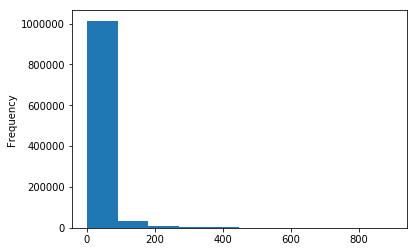

In [12]:
%matplotlib inline 
t1['active_mins'].plot.hist()
t1['active_mins'].describe()

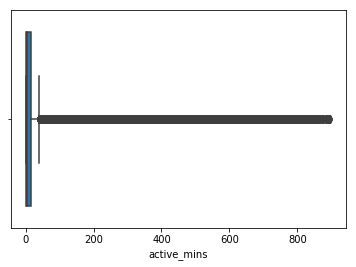

In [13]:
sns.boxplot(x=t1['active_mins'])
# we still observe some outliers. I will explore the possibility of filtering the out.

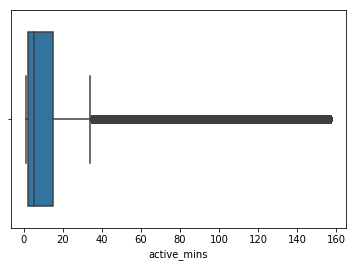

In [15]:
t1=t1[(t1.active_mins<(20+(3*46)))]
sns.boxplot(x=t1['active_mins'])

In [22]:
# compute IQ range to filter outliers
q1 = t1['active_mins'].quantile(0.25)
q3 = t1['active_mins'].quantile(0.75)
print(q1,q3)
iqr = q3 - q1
cutoff = 1.5*iqr
t1 = t1[((t1.active_mins)> q1 - cutoff)]
t1 = t1[((t1.active_mins)< q3 + cutoff)]

2.0 9.0


(828130, 3)

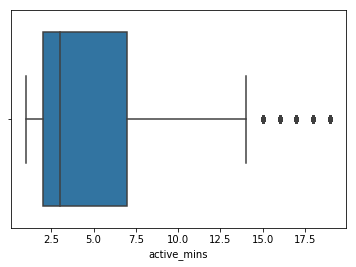

In [23]:
t1.shape
sns.boxplot(x=t1['active_mins'])

In [4]:
#This table contains users’ treatment assignment.
#Each row represents the assignment information for a unique user.
t2 = pd.read_csv("t2_user_variant.csv")
print("the number of records is ",t2.shape)
t2.head()

the number of records is  (50000, 4)


,uid,variant_number,dt,signup_date
0,0,0,2019-02-06,2018-09-24
1,1,0,2019-02-06,2016-11-07
2,2,0,2019-02-06,2018-09-17
3,3,0,2019-02-06,2018-03-04
4,4,0,2019-02-06,2017-03-09


In [26]:
# check that we have a unique value for dt.
t2.dt.unique()

array(['2019-02-06'], dtype=object)

In [162]:
t2.variant_number.value_counts()

0    40000
1    10000
Name: variant_number, dtype: int64

In [24]:
#join by userid 
merged_df = pd.merge(left=t1,right=t2, left_on='uid', right_on='uid')

In [48]:
len(merged_df.uid.unique())

46525

In [ ]:
merged_df.shape

In [42]:
merged_df.head(15)

,uid,dt_x,active_mins,variant_number,dt_y,signup_date
0,0,2019-02-22,5.0,0,2019-02-06,2018-09-24
1,0,2019-03-11,5.0,0,2019-02-06,2018-09-24
2,0,2019-03-18,3.0,0,2019-02-06,2018-09-24
3,0,2019-03-22,4.0,0,2019-02-06,2018-09-24
4,0,2019-04-03,9.0,0,2019-02-06,2018-09-24
5,0,2019-04-06,1.0,0,2019-02-06,2018-09-24
6,0,2019-04-17,1.0,0,2019-02-06,2018-09-24
7,0,2019-05-07,3.0,0,2019-02-06,2018-09-24
8,0,2019-05-14,1.0,0,2019-02-06,2018-09-24
9,0,2019-05-19,1.0,0,2019-02-06,2018-09-24


In [32]:
# double check that a user is only in one group
aux=merged_df.groupby('uid').variant_number.nunique()
max(aux)

1

In [38]:
merged_df.dtypes
min_date = min(merged_df['dt_x'])
max_date = max(merged_df['dt_x'])
print('min date is',min_date)
print('max date is',max_date)

min date is 2019-02-06
max date is 2019-07-05


In [40]:
# count records in each group
merged_df.variant_number.value_counts()


0    693417
1    134713
Name: variant_number, dtype: int64

In [46]:
# group by user to compute mean time across all his/her visit.
df = merged_df.groupby(['uid','variant_number'], as_index=False)['active_mins'].mean()
df.shape # we have 46525 unique users in both groups
df.variant_number.value_counts()

0    37362
1     9163
Name: variant_number, dtype: int64

In [53]:
df.head(10)
df.groupby('variant_number', as_index=False)['active_mins'].mean()

,variant_number,active_mins
0,0,4.149859
1,1,5.291342


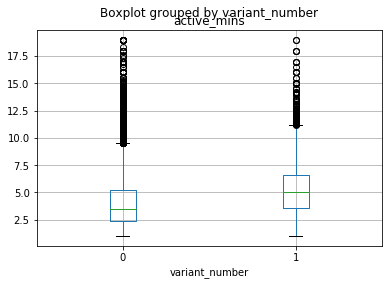

In [51]:
%matplotlib inline 
df.boxplot(column='active_mins',by='variant_number')

In [58]:
# compute confidence interval on difference of means.
stats = df.groupby(['variant_number'])['active_mins'].agg(['mean', 'count', 'std','var'])
stats


,mean,count,std,var
variant_number,,,,
0,4.149859,37362,2.40873,5.801981
1,5.291342,9163,2.34741,5.510334


In [60]:
stats.loc[0]['var']

5.80198115819105

In [65]:
import math
# estimated standard deviation of the difference between the two means.
sigma_dif = math.sqrt((stats.loc[0]['var']/stats.loc[0]['count'])+((stats.loc[1]['var']/stats.loc[1]['count'])))
upper = (stats.loc[1]['mean']-stats.loc[0]['mean']) + (1.96 * sigma_dif)
lower = (stats.loc[1]['mean']-stats.loc[0]['mean']) - (1.96 * sigma_dif)
print([lower,upper])


[1.08756830375531, 1.1953974370435352]


In [67]:
#This table contains active minutes data before the experiment started.
#It has a similar format as t1, except the dt range can extend before 
#the experiment start date.
t3 = pd.read_csv("t3_user_active_min_pre.csv")
print("the number of records is ",t3.shape)
t3.head()

the number of records is  (1190093, 3)


,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


count    1.189927e+06
mean     1.825735e+01
std      4.354546e+01
min      1.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      1.400000e+01
max      8.970000e+02
Name: active_mins, dtype: float64

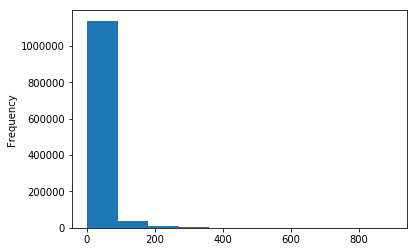

In [70]:
t3 = t3[(t3.active_mins<=1440)]
%matplotlib inline 
t3['active_mins'].plot.hist()
t3['active_mins'].describe()




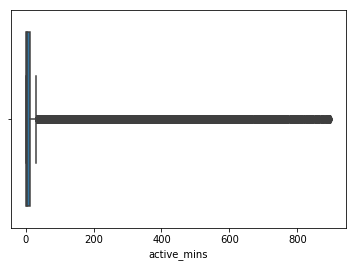

In [71]:
sns.boxplot(x=t3['active_mins'])

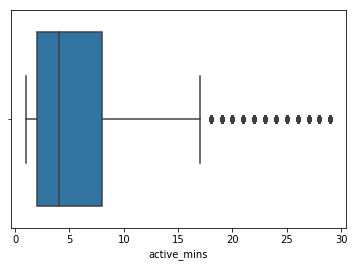

In [74]:
t3=t3[(t3.active_mins<(18.25+(3*43.54)))]
sns.boxplot(x=t3['active_mins'])

In [75]:
# compute IQ range to filter outliers
q1 = t3['active_mins'].quantile(0.25)
q3 = t3['active_mins'].quantile(0.75)
print(q1,q3)
iqr = q3 - q1
cutoff = 1.5*iqr
t3 = t3[((t3.active_mins)> q1 - cutoff)]
t3 = t3[((t3.active_mins)< q3 + cutoff)]

2.0 8.0


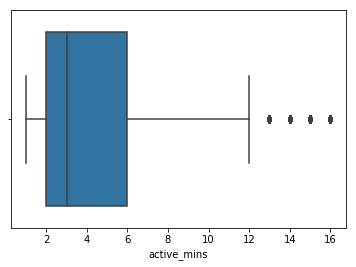

In [76]:
sns.boxplot(x=t3['active_mins'])

In [80]:
#check the dates of dataframe
min_date = min(t3['dt'])
max_date = max(t3['dt'])
print('min_date is',min_date)
print('max_date is',max_date)

min_date is 2018-08-10
max_date is 2019-02-05


In [81]:
merged_df2 = pd.merge(left=t3,right=t2, left_on='uid', right_on='uid')

In [82]:
merged_df2.head(10)

,uid,dt_x,active_mins,variant_number,dt_y,signup_date
0,0,2018-09-24,3.0,0,2019-02-06,2018-09-24
1,0,2018-11-08,4.0,0,2019-02-06,2018-09-24
2,0,2018-11-24,3.0,0,2019-02-06,2018-09-24
3,0,2018-11-28,6.0,0,2019-02-06,2018-09-24
4,0,2018-12-02,6.0,0,2019-02-06,2018-09-24
5,0,2018-12-04,1.0,0,2019-02-06,2018-09-24
6,0,2018-12-07,8.0,0,2019-02-06,2018-09-24
7,0,2018-12-09,5.0,0,2019-02-06,2018-09-24
8,0,2018-12-14,8.0,0,2019-02-06,2018-09-24
9,0,2018-12-15,2.0,0,2019-02-06,2018-09-24


In [84]:
merged_df2.variant_number.unique()
merged_df2.variant_number.value_counts()

0    754497
1    164195
Name: variant_number, dtype: int64

In [85]:
df2 = merged_df2.groupby(['uid','variant_number'], as_index=False)['active_mins'].mean()
df2.head()

,uid,variant_number,active_mins
0,0,0,3.333333
1,1,0,11.333333
2,2,0,3.700000
3,3,0,3.833333
4,4,0,2.357143


In [99]:
# mean before is computed based on all the users before the beginning of the experiment
mean_before = df2['active_mins'].mean()
var_before = df2['active_mins'].var()
n_before = df2.shape[0]

#compute the mean after rollout but only for users under treatment
mean_after = df[df.variant_number==1]['active_mins'].mean()
var_after = df[df.variant_number==1]['active_mins'].var()
n_after = df[df.variant_number==1].shape[0]

print(n_after)

#print('mean before',mean_before)
#print('mean after',mean_after)
 

9163


In [101]:
# estimated standard deviation of the difference between the two means.
sigma_dif = math.sqrt((var_before/n_before)+(var_after/n_after))
upper = (mean_after-mean_before) + (1.96 * sigma_dif)
lower = (mean_after-mean_before) - (1.96 * sigma_dif)
print([lower,upper])


[1.2698277548728634, 1.372264409083204]


In [103]:
#This table contains data about some user attributes.
#Each row represents attributes of a unique user.
t4 = pd.read_csv("t4_user_attributes.csv")
print("the number of records is ",t4.shape)
t4.head()

the number of records is  (50000, 3)


,uid,gender,user_type
0,0,male,non_reader
1,1,male,reader
2,2,male,non_reader
3,3,male,non_reader
4,4,male,non_reader


In [104]:
t5 = pd.merge(left=t4,right=t2, left_on='uid', right_on='uid')
t5.head()

,uid,gender,user_type,variant_number,dt,signup_date
0,0,male,non_reader,0,2019-02-06,2018-09-24
1,1,male,reader,0,2019-02-06,2016-11-07
2,2,male,non_reader,0,2019-02-06,2018-09-17
3,3,male,non_reader,0,2019-02-06,2018-03-04
4,4,male,non_reader,0,2019-02-06,2017-03-09


In [105]:
t5.shape

(50000, 6)

In [108]:
pd.crosstab(t5['variant_number'],t5['gender']).apply(lambda r: r/r.sum(), axis=1)

gender,female,male,unknown
variant_number,,,
0,0.290175,0.555925,0.1539
1,0.287000,0.552000,0.1610


In [109]:
pd.crosstab(t5['variant_number'],t5['user_type']).apply(lambda r: r/r.sum(), axis=1)

user_type,contributor,new_user,non_reader,reader
variant_number,,,,
0,0.022875,0.091325,0.717475,0.168325
1,0.012900,0.123500,0.736700,0.126900


In [110]:
pd.crosstab(t5['gender'],t5['user_type']).apply(lambda r: r/r.sum(), axis=1)

user_type,contributor,new_user,non_reader,reader
gender,,,,
female,0.017200,0.109898,0.723907,0.148995
male,0.024462,0.083619,0.716108,0.175812
unknown,0.014937,0.125676,0.735127,0.124260


In [111]:
merged_df3 = pd.merge(left=t1,right=t5, left_on='uid', right_on='uid')
merged_df3.head()

,uid,dt_x,active_mins,gender,user_type,variant_number,dt_y,signup_date
0,0,2019-02-22,5.0,male,non_reader,0,2019-02-06,2018-09-24
1,0,2019-03-11,5.0,male,non_reader,0,2019-02-06,2018-09-24
2,0,2019-03-18,3.0,male,non_reader,0,2019-02-06,2018-09-24
3,0,2019-03-22,4.0,male,non_reader,0,2019-02-06,2018-09-24
4,0,2019-04-03,9.0,male,non_reader,0,2019-02-06,2018-09-24


In [116]:
# group by user to compute mean time across all his/her visit.
df3 = merged_df3.groupby(['uid','variant_number','gender','user_type'], as_index=False)['active_mins'].mean()
df3.shape # we have 46525 unique users in both groups
#df3.variant_number.value_counts()

(46525, 5)

In [117]:
df3.head()

,uid,variant_number,gender,user_type,active_mins
0,0,0,male,non_reader,3.307692
1,1,0,male,reader,9.000000
2,2,0,male,non_reader,2.428571
3,3,0,male,non_reader,3.208333
4,4,0,male,non_reader,1.950000


In [171]:
df3.to_csv('df3_quora.csv')

In [122]:
#stats = df3.groupby(['variant_number','gender','user_type'])['active_mins'].agg(['mean', 'count', 'std','var'])
#stats = df3.groupby(['variant_number','gender'])['active_mins'].agg(['mean', 'count', 'std','var'])
stats = df3.groupby(['variant_number','user_type'])['active_mins'].agg(['mean', 'count', 'std','var']).reset_index()

stats

,variant_number,user_type,mean,count,std,var
0,0,contributor,8.067700,885,2.948805,8.695448
1,0,new_user,2.892973,2371,1.828464,3.343280
2,0,non_reader,3.471255,27442,1.679886,2.822016
3,0,reader,6.871204,6664,2.581401,6.663631
4,1,contributor,8.062027,124,2.507654,6.288329
5,1,new_user,4.414679,796,2.522767,6.364354
6,1,non_reader,4.919898,6994,2.034194,4.137944
7,1,reader,7.654943,1249,2.230615,4.975642


In [144]:
utype='contributor'
control = stats[(stats.variant_number==0) & (stats.user_type==utype)]
treat = stats[(stats.variant_number==1) & (stats.user_type==utype)]
#sigma_dif = math.sqrt((control['var'][0]/control['count'][0])+((treat['var'][0]/treat['count'][0])))
treat.iloc[0]['var']
    

6.2883294657262665

In [153]:
#create function to compute confidence interval given a user_type category and data frame stats
def ci_usertype(stats,utype):
    control = stats[(stats.variant_number==0) & (stats.user_type==utype)]
    treat = stats[(stats.variant_number==1) & (stats.user_type==utype)]

    sigma_dif = math.sqrt((control.iloc[0]['var']/control.iloc[0]['count'])+((treat.iloc[0]['var']/treat.iloc[0]['count'])))
    upper = (treat.iloc[0]['mean']-control.iloc[0]['mean']) + (1.96 * sigma_dif)
    lower = (treat.iloc[0]['mean']-control.iloc[0]['mean']) - (1.96 * sigma_dif)
    return (lower,upper)



(-0.4879189443104225, 0.47657393324998065)


In [155]:
# run the function on all unique user_type categories

utypes=stats['user_type'].unique()
utypes=utypes.tolist()
utypes

for u in utypes:
    inter = ci_usertype(stats,u)
    print(u, '--->', inter)
    


contributor ---> (-0.4879189443104225, 0.47657393324998065)
new_user ---> (1.3316220606045999, 1.7117911439585125)
non_reader ---> (1.3969912190555374, 1.5002947542414995)
reader ---> (0.6453729886947472, 0.9221051371502116)


In [156]:
stats2 = df3.groupby(['variant_number','gender'])['active_mins'].agg(['mean', 'count', 'std','var']).reset_index()

stats2

,variant_number,gender,mean,count,std,var
0,0,female,3.961722,10725,2.305638,5.315969
1,0,male,4.318368,20961,2.487382,6.187067
2,0,unknown,3.883059,5676,2.248822,5.057200
3,1,female,5.147343,2599,2.392395,5.723552
4,1,male,5.403433,5112,2.318357,5.374780
5,1,unknown,5.154455,1452,2.348080,5.513481


In [158]:
#create function to compute confidence interval given a user_type category and data frame stats
def ci_gender(stats,gen):
    control = stats[(stats.variant_number==0) & (stats.gender==gen)]
    treat = stats[(stats.variant_number==1) & (stats.gender==gen)]

    sigma_dif = math.sqrt((control.iloc[0]['var']/control.iloc[0]['count'])+((treat.iloc[0]['var']/treat.iloc[0]['count'])))
    upper = (treat.iloc[0]['mean']-control.iloc[0]['mean']) + (1.96 * sigma_dif)
    lower = (treat.iloc[0]['mean']-control.iloc[0]['mean']) - (1.96 * sigma_dif)
    return (lower,upper)


In [161]:
ugender=stats2['gender'].unique()
ugender=ugender.tolist()
ugender

for g in ugender:
    inter = ci_gender(stats2,g)
    print(g, '--->', inter)

female ---> (1.0838168999869435, 1.2874258861290009)
male ---> (1.0131414147714226, 1.1569885842349406)
unknown ---> (1.1371945853770327, 1.405597029108042)


In [163]:
stats3 = df3.groupby(['variant_number','gender','user_type'])['active_mins'].agg(['mean', 'count', 'std','var']).reset_index()
stats3

,variant_number,gender,user_type,mean,count,std,var
0,0,female,contributor,7.142652,220,2.676451,7.163392
1,0,female,new_user,2.822876,762,1.777076,3.157999
2,0,female,non_reader,3.374448,7935,1.700659,2.892242
3,0,female,reader,6.632086,1808,2.494685,6.223454
4,0,male,contributor,8.492587,572,2.924966,8.555426
5,0,male,new_user,2.955687,1132,1.840741,3.388328
6,0,male,non_reader,3.537730,15178,1.666697,2.777879
7,0,male,reader,7.015949,4079,2.611095,6.817815
8,0,unknown,contributor,7.642702,93,3.170050,10.049217
9,0,unknown,new_user,2.856120,477,1.878277,3.527926


In [167]:
covariates = [(a,b) for a in ugender for b in utypes]
covariates
len(covariates)

12

In [169]:
def ci_covariates(stats,cov):
    control = stats[(stats.variant_number==0) & (stats.gender==cov[0]) & (stats.user_type==cov[1])]
    treat = stats[(stats.variant_number==1) & (stats.gender==cov[0]) & (stats.user_type==cov[1])]

    sigma_dif = math.sqrt((control.iloc[0]['var']/control.iloc[0]['count'])+((treat.iloc[0]['var']/treat.iloc[0]['count'])))
    upper = (treat.iloc[0]['mean']-control.iloc[0]['mean']) + (1.96 * sigma_dif)
    lower = (treat.iloc[0]['mean']-control.iloc[0]['mean']) - (1.96 * sigma_dif)
    return (lower,upper)

In [170]:
for c in covariates:
    inter = ci_covariates(stats3,c)
    print(c, '--->', inter)

('female', 'contributor') ---> (-0.2181710324317161, 1.6209454206671288)
('female', 'new_user') ---> (1.3101518625750066, 1.9728603216581513)
('female', 'non_reader') ---> (1.3342376926849375, 1.5378077703842925)
('female', 'reader') ---> (0.613943688075681, 1.1294617876307897)
('male', 'contributor') ---> (-0.7743697022060778, 0.43061390495753704)
('male', 'new_user') ---> (1.1243689244004251, 1.6725771584888394)
('male', 'non_reader') ---> (1.3938146345782447, 1.5282684611886996)
('male', 'reader') ---> (0.5516221399068965, 0.9088071350362895)
('unknown', 'contributor') ---> (-1.781544948687302, 1.0656539264384974)
('unknown', 'new_user') ---> (1.179293254438179, 2.0517219238093998)
('unknown', 'non_reader') ---> (1.2893264050791, 1.5495292036690422)
('unknown', 'reader') ---> (0.48189251181388243, 1.2874962369534175)
